```
Roll Number: 19EE10039
Name: MANSI UNIYAL
Project Code: LMHC-AS
Project Title: Land Measurement Holding using Single Linkage Agglomerative (Bottom-Up) Clustering Technique
```



# importing libraries

In [ ]:
import time, random

startt = time.time() # noting the starting time

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# ignoring all warnings in the output of the cell
import warnings

warnings.filterwarnings("ignore")

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import jaccard_score

# preparing data

In [ ]:
# reading data from csv file
df = pd.read_csv("land.csv")
df.columns = df.iloc[0]  # adjusting the column name
df = df.drop([0]).reset_index(drop=True)
df = df.drop(
    columns=["S. No."]
)  # droping the column as it just gives the values of index

print(df.shape)
df.head(2)

(4326, 10)


0 Category   Crop                       State Avg area of marginal holdings  \
0  Cereals  Paddy  Andhra Pradesh & Telangana                          0.48   
1  Cereals  Paddy                       Assam                          0.42   

0 Avg area of small land holdings Avg area of semi medium land holdings  \
0                            1.23                                  2.38   
1                            1.25                                  2.45   

0 Avg area of medium land holdings Avg area of large land holdings  \
0                             3.71                            6.29   
1                             4.67                           44.20   

0 Avg area of institutional land holdings Avg area of total land holdings  
0                                    5.18                            0.93  
1                                   31.09                            1.01

In [ ]:
# label encoding for clustering numerical data rather than object/string values
label_encoder = preprocessing.LabelEncoder()
for x in df.columns:  # preprocessing for all values of columns
    df[x] = label_encoder.fit_transform(df[x])

X_train = StandardScaler().fit_transform(df)  # normalizing
df.head(2)  # non-standarized form

0  Category  Crop  State  Avg area of marginal holdings  \
0         1   128      0                             49   
1         1   128      1                             43   

0  Avg area of small land holdings  Avg area of semi medium land holdings  \
0                              124                                    232   
1                              126                                    238   

0  Avg area of medium land holdings  Avg area of large land holdings  \
0                               343                              654   
1                               396                              585   

0  Avg area of institutional land holdings  Avg area of total land holdings  
0                                      414                               94  
1                                      354                              102

# k-means clustering functionalities

In [ ]:
# def euclidean(A, B): # euclidean distance between two points
#     return np.sqrt(np.sum((A - B)**2, axis=1))


def cosine_dist(A, B):
    """finds the cosine distance two points A, B
    Returns:
        np.array: [50,1] cosine distance values
    """
    return cdist(np.array(A).reshape([-1, 1]).T, np.array(B)).reshape([-1])

In [ ]:
class model_kmeans:
    """model class with functionality for fitting with cosine distance values
    and evalute with respect to the centroids saved
    """

    def __init__(self, clusters_total=3, iter_total=20):
        self.clusters_total = clusters_total
        self.iter_total = iter_total

    def fit(self, data):
        """for total number of interations (default as 20) we update the values of centroids
        1. randomly choose value of k number of centroids initialized
        2. calculate cosine distances of each data point and assign to nearest centroid
        3. update the value of centroid as the center of the assigned datapoints of that cluster
        4. iterate till convergence or till the number of iterations reach the total iterations value
        Args:
            data (np.array): input data points
        """
        self.centroids = [
            random.choice(data)
        ]  # randomly choose the centroids from data point
        iter_number, previous_centroids = (
            0,
            None,
        )  # initialize the iterationvalue and centroids position

        for _ in range(self.clusters_total - 1):
            distances = np.sum(
                [cosine_dist(centroid, data) for centroid in self.centroids], axis=0
            )
            distances /= np.sum(distances)
            (updated_index,) = np.random.choice(range(len(data)), size=1, p=distances)
            self.centroids += [data[updated_index]]

        while (
            np.not_equal(self.centroids, previous_centroids).any()
            and iter_number < self.iter_total
        ):
            sorted_points = [[] for _ in range(self.clusters_total)]
            for x in data:
                distances = cosine_dist(x, self.centroids)
                sorted_points[np.argmin(distances)].append(x)
            previous_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            # updating value of centroid as mean of the cluster
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[i] = previous_centroids[i]
            iter_number += 1

    def test(self, data):
        """finally allocates the data points into clusters with respect
        to the final iterated value of centroids
        Returns:
            centroids: list of centroids index
            centroid_id: list of which data is assigned to which centroid
        """
        centroids, centroid_id = [], []
        for i in data:
            distances = cosine_dist(i, self.centroids)
            centroid_index = np.argmin(distances)
            centroids.append(self.centroids[centroid_index])
            centroid_id.append(centroid_index)
        return centroids, centroid_id

In [ ]:
def call_kmeans(data, centers=3, printval=False):
    """function calls the model class of kmeans and fits the data points,
    it then prints the plotted centroid (if printval key is True)(ie. for 2d data)
    it evaluates the silhouettescore and returns the value
    Args:
        data (np.array): input data points
        centers (int): number of clusters to be formed: default value is 3
        printval (bool): if visualization of clustering is to be plotted: default value is False
    Returns:
        silhouette_score: float value for the score of clustering
        classification: list of each data point assoicated to each cluster
    """
    kmeans = model_kmeans(clusters_total=centers)
    kmeans.fit(data)  # forming the clusters on the data points
    _, classification = kmeans.test(data)  # returning the so formed cluster values
    # calculating the silhouette coefficient
    silhouette_avg = silhouette_score(data, classification, metric="cosine")

    if printval:  # if data is 2d and needs to be visualized into clusters
        print(
            "Silhouette coefficient for",
            centers,
            "clusters is:",
            np.round(silhouette_avg, 4),
        )
        plt.figure(figsize=[4, 3])  # plotting  scatter data points
        sns.scatterplot(
            x=[X[0] for X in data],
            y=[X[1] for X in data],
            hue=classification,
            palette="deep",
            legend=None,
        )
        plt.plot(
            [x for x, _ in kmeans.centroids],
            [y for _, y in kmeans.centroids],
            "k+",
            markersize=12,
        )  # plotting the centroids with a plus symbol mark
        plt.show()

    return np.round(silhouette_avg, 4), classification

#visualizing on 2D transformed data

In [ ]:
# transforming to 2 feature plane to see the visualization of kmeans working on data
X_train_PCA = PCA(2).fit_transform(X_train)
X_train_PCA.shape

(4326, 2)

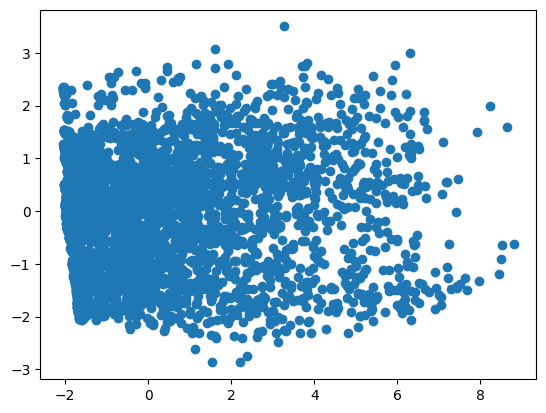

In [ ]:
# 2D representation of the land data
plt.scatter(x=X_train_PCA[:, 0], y=X_train_PCA[:, 1])

Silhouette coefficient for 2 clusters is: 0.572


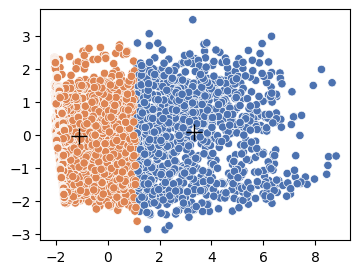

Silhouette coefficient for 3 clusters is: 0.457


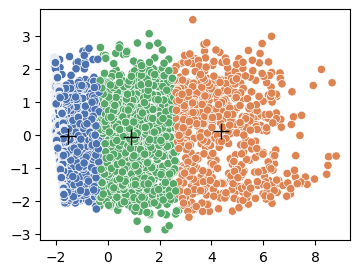

Silhouette coefficient for 4 clusters is: 0.4384


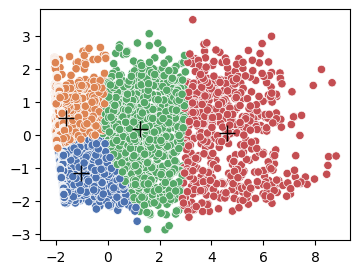

Silhouette coefficient for 5 clusters is: 0.4772


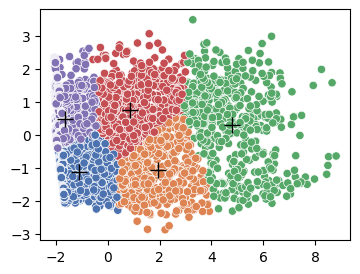

Silhouette coefficient for 6 clusters is: 0.2877


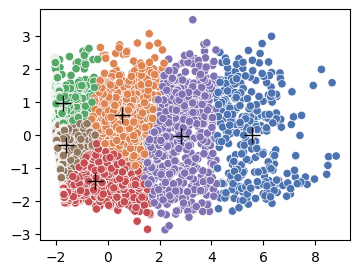

In [ ]:
# for each value of k=number of centers plotting the clusters and score
for i in range(5):
    call_kmeans(X_train_PCA, centers=2 + i, printval=True)

# performing on data for various k and calculating the scores

In [ ]:
# initializing a dataframe for storing the evaluation
results = pd.DataFrame([], columns=["k", "silhouette score"], dtype="float")
results

Empty DataFrame
Columns: [k, silhouette score]
Index: []

In [ ]:
# calculating the scores 5 times to remove any doubts on random initization
for j in range(5):
    # for each value of k=number of centers plotting the clusters and score
    for i in range(6):
        score, _ = call_kmeans(X_train, centers=i + 2, printval=False)
        results.loc[i, "k"] = i + 2
        if j == 0:
            results.loc[i, "silhouette score"] = 0.0
        results.loc[i, "silhouette score"] += score
        if j == 4:  # averaging the values for each k number of clusters
            results.loc[i, "silhouette score"] /= 5.0

results

k  silhouette score
0  2.0           0.42704
1  3.0           0.33702
2  4.0           0.27674
3  5.0           0.23476
4  6.0           0.22602
5  7.0           0.23232

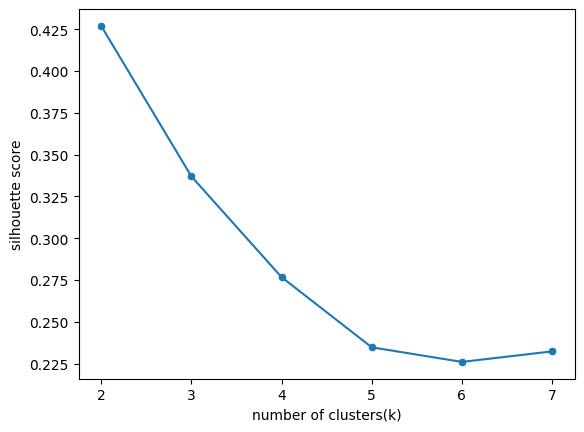

In [ ]:
# visualizing the findings, effect of increasing the number of clusters on silhouette score
sns.scatterplot(x=results["k"], y=results["silhouette score"])
plt.plot(results["k"], results["silhouette score"])
plt.xlabel("number of clusters(k)")
plt.ylabel("silhouette score")
plt.show()

# Agglomerative bottom-up hierarchical clustering

single linkage:- means distance between two clusters is the **minimum** distance between members of the two clusters

complete linkage:- means distance between two clusters is the **mean** distance between all the members of the two clusters


In [ ]:
def hierarchical_cluster(centers, data, print_val):
    """function initializes Agglomerative clustering model and fits the data points,
    it then prints the plotted clusters (if printval key is True)(ie. for 2d data)
    it evaluates the silhouette score
    Args:
        centers (int): number of clusters to be formed
        data (np.array): input data points
        print_val (bool): if visualization of clustering is to be plotted
    Returns:
        silhouette_score: float value for the score of clustering
    """
    # initializing the clustering model
    hiercluster = AgglomerativeClustering(affinity="cosine", linkage="complete")
    hiercluster.set_params(n_clusters=centers) # setting the maximum number of clusters
    clusters = hiercluster.fit_predict(data) # fitting the training dataset
    avg_score = silhouette_score(data, clusters, metric="cosine") # calculating the score

    if print_val: 
        print(
            "Silhouette coefficient for",
            centers,
            "clusters is:",
            np.round(avg_score, 4),
        )

        plt.figure(figsize=[4, 3])  # plotting  scatter data points of clusters
        sns.scatterplot(
            x=[X[0] for X in data],
            y=[X[1] for X in data],
            hue=clusters,
            palette="bright",
            legend=None,
        )
        plt.show()
    return avg_score

# visualizing for 2d transformed data

Silhouette coefficient for 2 clusters is: 0.7133


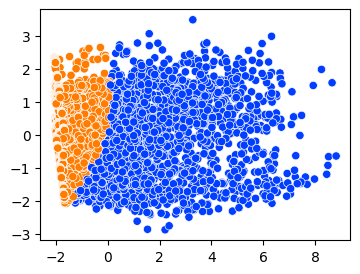

Silhouette coefficient for 3 clusters is: 0.6784


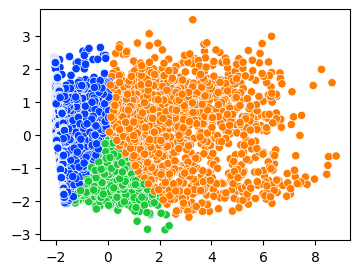

Silhouette coefficient for 4 clusters is: 0.5456


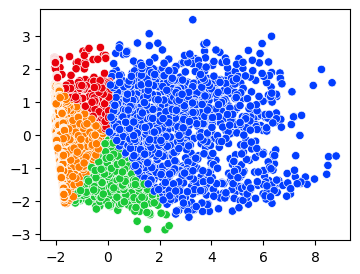

Silhouette coefficient for 5 clusters is: 0.5355


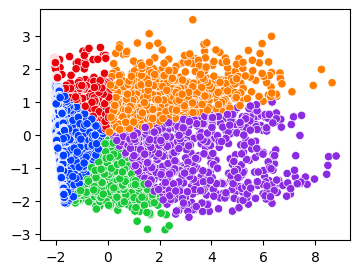

Silhouette coefficient for 6 clusters is: 0.6255


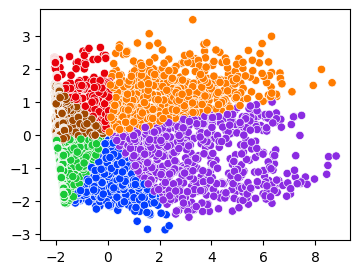

In [ ]:
# for range of k values visualize the clustering on 2d data initially
for i in range(2, 7):
    _ = hierarchical_cluster(i, X_train_PCA, True)

# plotting dendrogram diagram for 2d data, k=2 

In [ ]:
# for the optimum value of k (=2) with maximum value of score
hiercluster = AgglomerativeClustering(affinity="cosine", linkage="complete")

hiercluster.set_params(n_clusters=2)
clusters = hiercluster.fit_predict(X_train_PCA)

X_scaled_clustered = pd.DataFrame(X_train_PCA)
X_scaled_clustered["cluster"] = clusters

X_scaled_clustered.head(2)

0         1  cluster
0  6.282326  1.068142        0
1  6.194719  1.218010        0

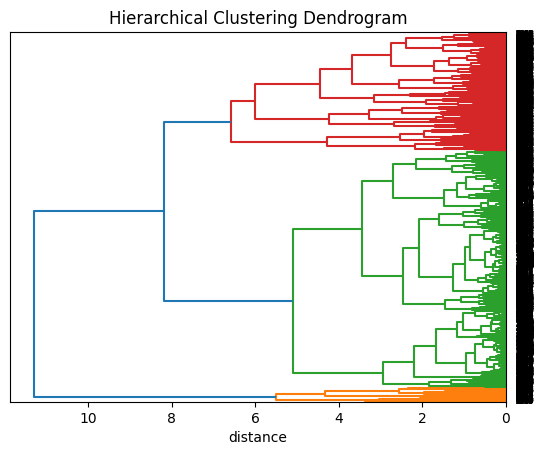

In [ ]:
Z = linkage(X_scaled_clustered, "complete")  # for scaled 2d data
names = X_scaled_clustered.index
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("distance")
dendrogram( # plotting the dendrogram (forming of clusters of each data point)
    Z,
    labels=names,
    orientation="left",
)
plt.show()

# performing on data for various k and calculating the scores

In [ ]:
# initializing a dataframe for storing the evaluation
results_h = pd.DataFrame([], columns=["k", "silhouette score"], dtype="float")
results_h

Empty DataFrame
Columns: [k, silhouette score]
Index: []

In [ ]:
# calculating the scores 5 times to remove any doubts on random initization
for j in range(5):
    # for each value of k=number of centers plotting the clusters and score
    for i in range(6):
        score = hierarchical_cluster(i + 2, X_train, False)
        results_h.loc[i, "k"] = i + 2
        if j == 0:
            results_h.loc[i, "silhouette score"] = 0.0
        results_h.loc[i, "silhouette score"] += score
        if j == 4:  # averaging the values for each k number of clusters
            results_h.loc[i, "silhouette score"] /= 5.0

results_h

k  silhouette score
0  2.0          0.317496
1  3.0          0.251105
2  4.0          0.243531
3  5.0          0.224377
4  6.0          0.175537
5  7.0          0.170897

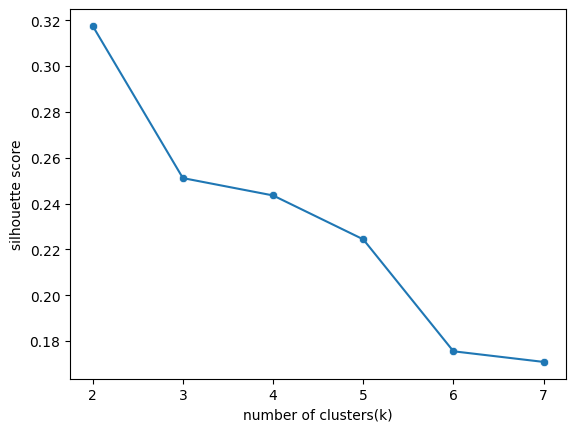

In [ ]:
# visualizing the findings, effect of increasing the number of clusters on silhouette score
sns.scatterplot(x=results_h["k"], y=results_h["silhouette score"])
plt.plot(results_h["k"], results_h["silhouette score"])
plt.xlabel("number of clusters(k)")
plt.ylabel("silhouette score")
plt.show()

# jaccard similarity

In [ ]:
# for each value of k finding the jaccard similarity between the clusters 
# obtained from kmeans and hierarchical clustering 
for i in range(6):
    # hierarchical clustering 
    hiercluster = AgglomerativeClustering(affinity="cosine", linkage="complete")
    hiercluster.set_params(n_clusters=i + 2)
    clusters = hiercluster.fit_predict(X_train)

    # k-means clustering
    score, classification = call_kmeans(X_train, centers=i + 2, printval=False)

    print(
        "jaccard similarity for clusters",
        i + 2,
        np.round(jaccard_score(classification, clusters, average="weighted"), 5),
    )

jaccard similarity for clusters 2 0.65155
jaccard similarity for clusters 3 0.04587
jaccard similarity for clusters 4 0.12862
jaccard similarity for clusters 5 0.15066
jaccard similarity for clusters 6 0.11889
jaccard similarity for clusters 7 0.13613


# conclusion for optimum k=2

In [ ]:
# storing the clusters for optimum value of k obtained from both methods

# k-means clustering
score, classification = call_kmeans(X_train, centers=2, printval=False)
df["kmeans"] = classification

# hierachical clustering
hiercluster = AgglomerativeClustering(affinity="cosine", linkage="complete")
hiercluster.set_params(n_clusters=2)
clusters = hiercluster.fit_predict(X_train)
df["TopDown"] = clusters

# changing the notation of 0,1 for hierarchical clustering as it was taken opposite
# from observation*
df.loc[df["kmeans"] == 0, ["kmeans"]] = 2
df.loc[df["kmeans"] == 1, ["kmeans"]] = 0
df.loc[df["kmeans"] == 2, ["kmeans"]] = 1

df.head(3)

0  Category  Crop  State  Avg area of marginal holdings  \
0         1   128      0                             49   
1         1   128      1                             43   
2         1   128      2                             25   

0  Avg area of small land holdings  Avg area of semi medium land holdings  \
0                              124                                    232   
1                              126                                    238   
2                              114                                    228   

0  Avg area of medium land holdings  Avg area of large land holdings  \
0                               343                              654   
1                               396                              585   
2                               386                              248   

0  Avg area of institutional land holdings  Avg area of total land holdings  \
0                                      414                               94   
1                                      354                              102   
2                                       93                               38   

0  kmeans  TopDown  
0       0        0  
1       0        0  
2       0        0

In [ ]:
# printing the jaccard similarity between the 2 obatined clustering techniques
print(
    "jaccard similarity for 2 clusters",
    np.round(jaccard_score(df["kmeans"], df["TopDown"], average="binary"), 5),
)

# classes of k=2 clustering saved
first_class_kmeans = df.loc[df["kmeans"] == 0, :].copy().index
first_class_topdown = df.loc[df["TopDown"] == 0, :].copy().index
second_class_kmeans = df.loc[df["kmeans"] == 1, :].copy().index
second_class_topdown = df.loc[df["TopDown"] == 1, :].copy().index

jaccard similarity for 2 clusters 0.69723


In [ ]:
# distribution of clusters in kmeans clustering ~ skewed distribution
len(first_class_kmeans), len(second_class_kmeans)

(1068, 3258)

In [ ]:
# distribution of clusters in hierarchical clustering ~ uniformly distributed
len(first_class_topdown), len(second_class_topdown)

(2012, 2314)

# saving the txt files

In [ ]:
# txt file contains the final cluster information considering optimal number of clusters
file = open("kmeans.txt", "w")
file.writelines(str(list(np.array(first_class_kmeans, dtype="object"))))
file.writelines("\n")
file.writelines(str(list(np.array(second_class_kmeans, dtype="object"))))
file.close()

In [ ]:
# txt file contains the final cluster information considering optimal number of clusters
file = open("agglomerative.txt", "w")
file.writelines(str(list(np.array(first_class_topdown, dtype="object"))))
file.writelines("\n")
file.writelines(str(list(np.array(second_class_topdown, dtype="object"))))
file.close()

In [ ]:
# printing the time it took to run the whole code
endt = time.time()
print((endt - startt) / 60, "minutes")

3.3679956714312236 minutes
